In [1]:
import gc

import torch
from datasets import load_from_disk, Dataset
import string
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import multiprocessing
from tqdm import trange
import pandas as pd

In [2]:
import datasets
from datasets import disable_caching
disable_caching()

In [3]:
datasets.config.IN_MEMORY_MAX_SIZE = 0.1
NUM_PROC = multiprocessing.cpu_count() // 2
NUM_PROC

56

In [4]:
ds = load_from_disk(dataset_path="../data/datasets/pl/text/")
# ds = ds.to_iterable_dataset()

In [5]:
tokenizer_mistral = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
tokenizer_llama = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

In [6]:
def tagger(item):
    text = item["content"]
    dummy_tokens = text.split()

    item["chars"] = len(text)
    item["num_words"] = len(dummy_tokens)
    item["num_non_ws_tokens"] = sum(
        1 for tok in dummy_tokens if any(char not in string.punctuation for char in tok.strip())
    )
    # item["num_tokens_mistral"] = tokenizer_mistral(text, return_length=True,  return_attention_mask=False, padding=False, truncation=False)["length"][0]
    # gc.collect()
    # torch.cuda.empty_cache()
    return item

ds = ds.map(tagger, num_proc=NUM_PROC, remove_columns=['excerpt', 'content', 'text', 'date', 'num_pages', 'vol_number', 'vol_type'])
ds.cleanup_cache_files()

Map (num_proc=56):   0%|          | 0/408423 [00:00<?, ? examples/s]

0

In [7]:
# texts = list(ds["text"][:10])
# texts_ds = Dataset.from_dict({"text": texts})

In [8]:
text_ds = load_from_disk(dataset_path="../data/datasets/pl/text/").select_columns(['text'])

In [9]:
def tokenization(examples):
    return {"num_tokens_mistral": tokenizer_mistral(examples["text"], return_length=True,  return_attention_mask=False, padding=False, truncation=False)["length"]}

texts_ds = text_ds.map(tokenization, batched=True, num_proc=30, remove_columns=["text"])

Map (num_proc=30):   0%|          | 0/408423 [00:00<?, ? examples/s]

In [14]:
stats = (
    ds.select_columns(["_id", "type", "chars", "num_words", "num_non_ws_tokens"])
    .to_pandas()
    .convert_dtypes(dtype_backend="pyarrow")
)
stats = pd.concat([stats, texts_ds.to_pandas()], axis=1)
stats["type"] = stats["type"].astype("category")
stats.head()

,_id,type,chars,num_words,num_non_ws_tokens,num_tokens_mistral
0,154505000005127_XVII_AmA_000014_1994_Uz_1994-0...,"SENTENCE, REASON",28109,3344,3323,8974
1,151500000001006_II_AKa_000031_1998_Uz_2013-02-...,"SENTENCE, REASON",61750,7764,7710,18034
2,151500000001006_II_AKa_000043_1999_Uz_1999-04-...,"SENTENCE, REASON",8038,903,901,2402
3,151500000001006_II_AKa_000072_1999_Uz_1999-05-...,"SENTENCE, REASON",8129,924,922,2025
4,151500000001006_II_AKa_000115_1999_Uz_1999-05-...,"SENTENCE, REASON",10920,1293,1292,3643


[Text(0.5, 1.0, '#tokens distribution')]

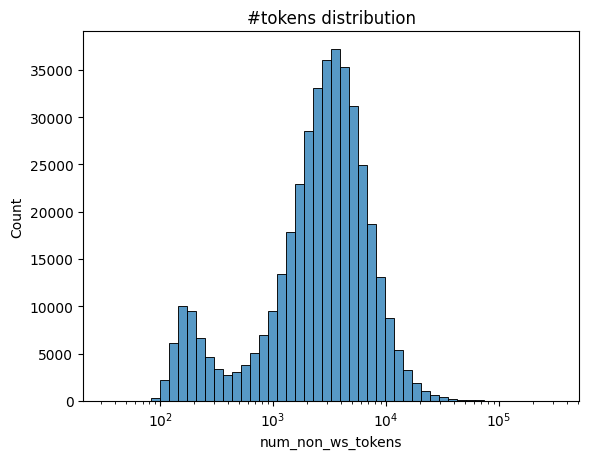

In [15]:
ax = sns.histplot(
    x=stats["num_non_ws_tokens"],
    log_scale=True,
    bins=50,
)
ax.set(title="#tokens distribution")

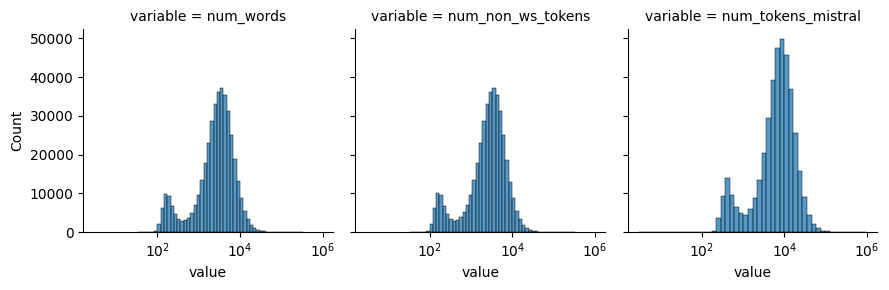

In [16]:
g = sns.FacetGrid(stats[["num_words", "num_non_ws_tokens", "num_tokens_mistral"]].melt(), col="variable", sharex=True)
g.map(sns.histplot, "value", bins=50, log_scale=True)

<Axes: xlabel='value', ylabel='variable'>

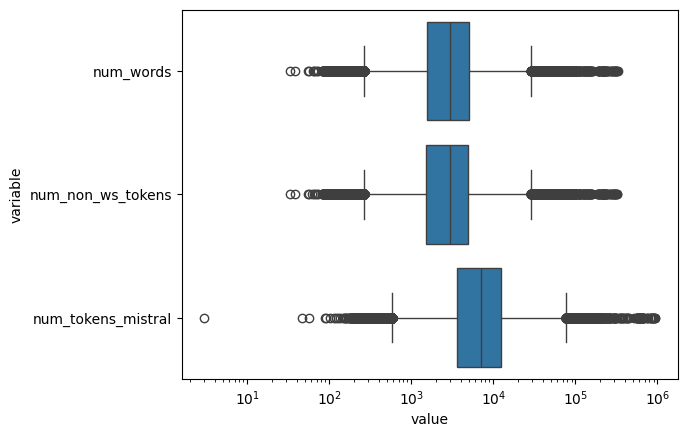

In [17]:
sns.boxplot(stats[["num_words", "num_non_ws_tokens", "num_tokens_mistral"]].melt(), y="variable", x="value", log_scale=True)

In [18]:
stats[["num_words", "num_non_ws_tokens", "num_tokens_mistral"]].describe()

,num_words,num_non_ws_tokens,num_tokens_mistral
count,408423.0,408423.0,408423.000000
mean,3892.239394,3856.938238,9495.509832
std,4948.390653,4899.915682,12389.130175
min,33.0,33.0,3.000000
25%,1542.0,1528.0,3633.000000
50%,2966.0,2940.0,7178.000000
75%,4994.0,4950.0,12265.000000
max,329834.0,325779.0,944250.000000


In [22]:
print(f"Percent of documents longer than 32k tokens: {(stats.num_tokens_mistral > 32_000).mean():.2%}")

Percent of documents longer than 32k tokens: 2.68%


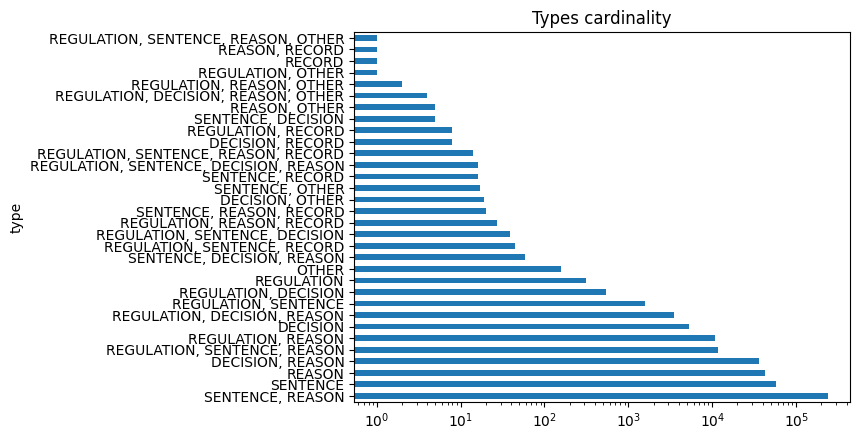

In [19]:
card_order = stats["type"].value_counts().index.tolist()
data = stats["type"].value_counts().plot.barh(logx=True, title="Types cardinality")

<Axes: title={'center': 'Per type text length ditribution'}, xlabel='num_non_ws_tokens', ylabel='type'>

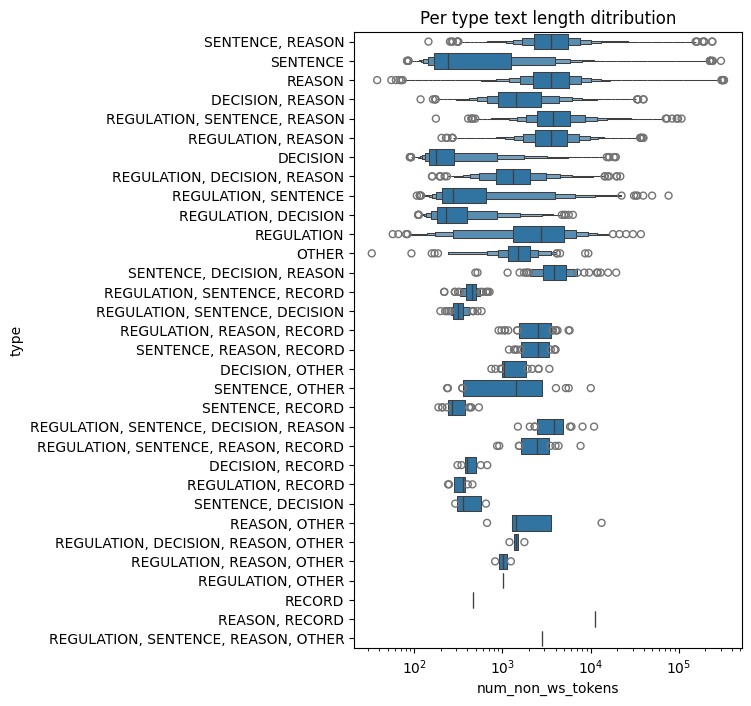

In [20]:
_, ax = plt.subplots(figsize=(5, 8))
ax.set(title="Per type text length ditribution")
sns.boxenplot(data=stats, y="type", x="num_non_ws_tokens", order=card_order, log_scale=True)